In [1]:
#%%
# the imports for the program
import os
import numpy as np # both for data manipulation
import pandas as pd

from sklearn.preprocessing import LabelEncoder #  categorical variables

import warnings
warnings.filterwarnings('ignore') # Suppress warnings

import matplotlib.pyplot as plt   # for plotting
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer # imputer for handling missing values
from sklearn.preprocessing import PolynomialFeatures #
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression


['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv', 'homework1A.py', 'log_reg_baseline.csv', 'random_forest_baseline.csv', 'random_forest_baseline_engineered.csv', 'HW.py']
Training data shape:  (307511, 122)
Testing data shape:  (48744, 121)


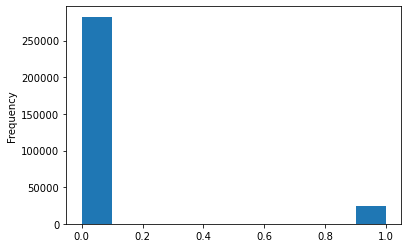

In [4]:
###info about the data files
#directory list
print(os.listdir("E:\DataSets\LoanCredit"))

# Training data information/shape
app_train = pd.read_csv('E:\DataSets\LoanCredit/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

# Testing data features
app_test = pd.read_csv('E:\DataSets\LoanCredit/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()


## Looking at the variable we are trainin the model on, TARGET
# and its distribution which shows the data is skewed with more loans being paid
app_train['TARGET'].value_counts()
app_train['TARGET'].astype(int).plot.hist();


In [17]:
# to save on computational power, we can look disregard columns with too many
#missing variables
# Function to calculate missing values by column#
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
                                                              "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

# This allows us to look at the stats of missing values
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)
#considering data types and unique classes
app_train.dtypes.value_counts()

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


float64    65
int64      41
object     16
dtype: int64

In [18]:
#this part was a little more confusing to understand what was going on with the code
# but this allows us to deal with categorical variables
# for 2 unique categories
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])

            # Keep track of how many columns were label encoded
            le_count += 1

print('%d columns were label encoded.' % le_count)

# for more than 2 categories hot encoding used without arbitrary values
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

3 columns were label encoded.
Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [19]:
# there were some differences in the data set up of the test and the training data so those discrepancies need to be aligned
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape) 

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


In [58]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(10))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
DAYS_BIRTH                             -0.078239
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.05470

In [21]:
# looks like the strong positive correlations are the days_birth,region with city, 
# the strongest negative correlations are the 3 ext sources  

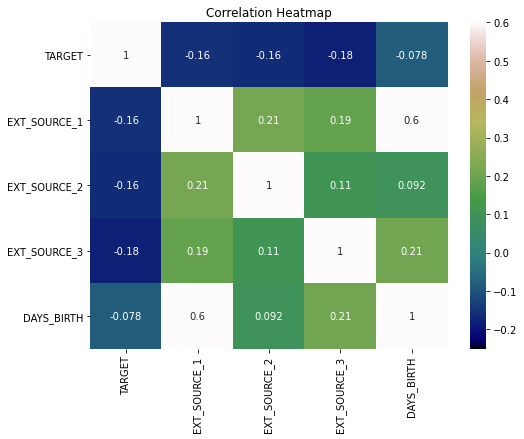

In [57]:
# This shows the correlation in the continuous variables.
# of the top 3 variables, since its a little easier since they are continuous

ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.gist_earth, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

In [9]:
# this correlation heat map of the top correlations, negative and positve. This shows an interesting correlation between EXT_SOURCE_1 and EXT_SOUR

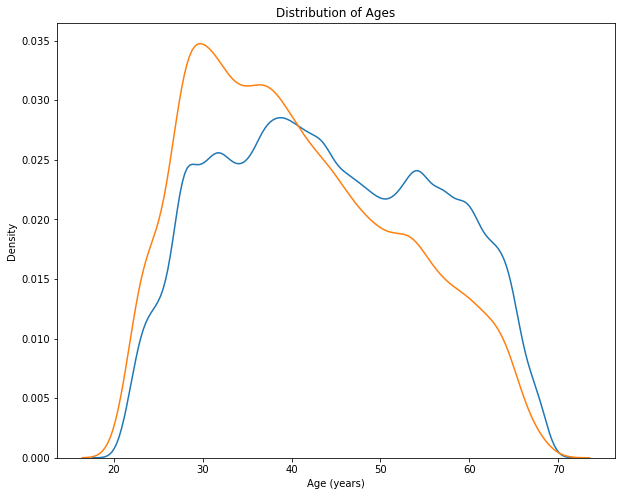

In [59]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [23]:
# Target 1 means there were problems in repayment of the loans and blue means they were able to pay the loan.
# from this figure we see that target 1 is skewed toward younger customers. While older customers had target 0 
# and had less trouble repaying their loans

In [61]:
# the same for the top 3 negative correlations, I do not know what these variables mean but they 
# have quite the predicting power

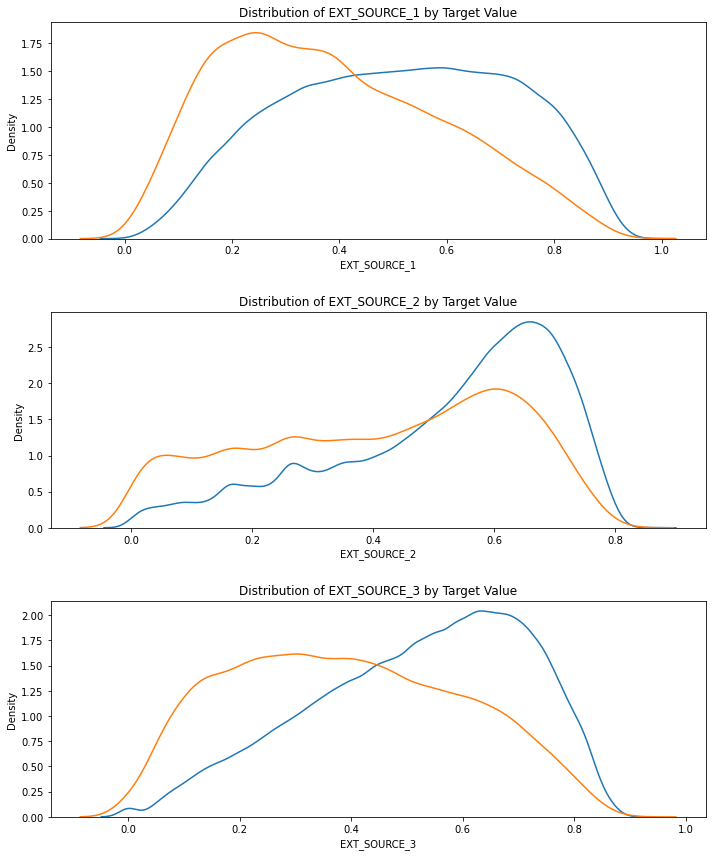

In [60]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3' ]):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

In [8]:
# This is a strong negative correlation but I am not sure what these variables mean
# so we can tell that there some cool correlations in the data to work with and.
# good indicators of paying back a loan

In [18]:
# checking marriage because commitment may mean something


import plotly.graph_objs as go
from plotly.offline import iplot
temp = app_train["NAME_FAMILY_STATUS"].value_counts()
#print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(app_train['TARGET'][app_train['NAME_FAMILY_STATUS']==val] == 1))
    temp_y0.append(np.sum(app_train['TARGET'][app_train['NAME_FAMILY_STATUS']==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = (temp_y1 / temp.sum()) * 100,
    name='YES'
)
trace2 = go.Bar(
    x = temp.index,
    y = (temp_y0 / temp.sum()) * 100, 
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Family Status of Applicant's in terms of loan is repayed or not in %",
    #barmode='stack',
    width = 1000,
    xaxis=dict(
        title='Family Status',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [16]:
# comparing income type to the % pay 


import plotly.graph_objs as go
from plotly.offline import iplot
temp = app_train["NAME_INCOME_TYPE"].value_counts()
#print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(app_train['TARGET'][app_train['NAME_INCOME_TYPE']==val] == 1))
    temp_y0.append(np.sum(app_train['TARGET'][app_train['NAME_INCOME_TYPE']==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = (temp_y1 / temp.sum()) * 100,
    name='YES'
)
trace2 = go.Bar(
    x = temp.index,
    y = (temp_y0 / temp.sum()) * 100, 
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Income Type Compared to pay back in %",
    #barmode='stack',
    width = 1000,
    xaxis=dict(
        title='Income Type',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [19]:
# Checking by gender out of curiosity, looks like 

temp = app_train["CODE_GENDER"].value_counts()
#print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(app_train['TARGET'][app_train['CODE_GENDER']==val] == 1))
    temp_y0.append(np.sum(app_train['TARGET'][app_train['CODE_GENDER']==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = (temp_y1 / temp.sum()) * 100,
    name='YES'
)
trace2 = go.Bar(
    x = temp.index,
    y = (temp_y0 / temp.sum()) * 100, 
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Income Type Compared to pay back in %",
    #barmode='stack',
    width = 1000,
    xaxis=dict(
        title='Income Type',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [20]:
# Checking by gender out of curiosity, looks like 

temp = app_train["CODE_GENDER"].value_counts()
#print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(app_train['TARGET'][app_train['CODE_GENDER']==val] == 1))
    temp_y0.append(np.sum(app_train['TARGET'][app_train['CODE_GENDER']==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = (temp_y1 / temp.sum()) * 100,
    name='YES'
)
trace2 = go.Bar(
    x = temp.index,
    y = (temp_y0 / temp.sum()) * 100, 
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Gender code Compared to payback in %",
    #barmode='stack',
    width = 1000,
    xaxis=dict(
        title='Gender',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [ ]:
# sources cited

#Lathwal (2018) Complete EDA + Feature Importance (version 27). Kaggle.
#Will Koehrsen (2018) Start Here: A Gentle Introduction (version 17).Kaggle.
